<a href="https://colab.research.google.com/github/Twet-ta/DS/blob/main/DL2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задание №2 по курсу "Прикладная алгебра"**

---
#Классификация по представлениям из трансформера
---
---

*Выполнила: Дмитриева Татьяна, 317 группа*

**Аннотация**

Цель данного исследования заключалась в том, чтобы наиболее качественно классифицировать текстовые данные по представлениям из трансформера. \
Для этого были использованы несколько трансформеров, из которых различными способами были получены представления для текстовых данных. Затем с помощью полученных данных были обучены некоторые классические модели ML и с помощью них проведена классификация. \
По результатам проведенных опытов было выбран наиболее подходящий под эти задачи трансформер и способ изъятия из него представлений. Также была выбрана ML модель, которая справлялась с классификацией лучше всего после обучения на выбранном представлении.



**Материалы**

Для данного исследования было решено использовать [данные](https://huggingface.co/datasets/rotten_tomatoes), содержащие отзывы на фильмы с сайта [rottentomatoes](https://www.rottentomatoes.com/). Требовалось предсказать, является ли отзыв положительным или отрицательным. \
Количество положительных и отрицательных объектов в данной выборке сбалансировано, поэтому далее будем использовать метрику accuracy.

#Импортирование и подготовка необходимых данных

In [ ]:
!pip install sentencepiece

In [ ]:
!pip install transformers datasets

In [ ]:
!pip install xgboost
!pip install catboost

In [ ]:
from datasets import load_dataset

In [ ]:
import pickle
import numpy as np
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, RobertaTokenizer, RobertaModel, AlbertTokenizer, AlbertModel
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


#https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

In [ ]:
ds = load_dataset('rotten_tomatoes')
PRE_TRAINED_MODEL_NAME = 'bert-large-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
train = ds['train']
test = ds['test']

In [ ]:
lens2 = [len(tokenizer.tokenize(test['text'][i])) for i in range(len(test['text']))]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


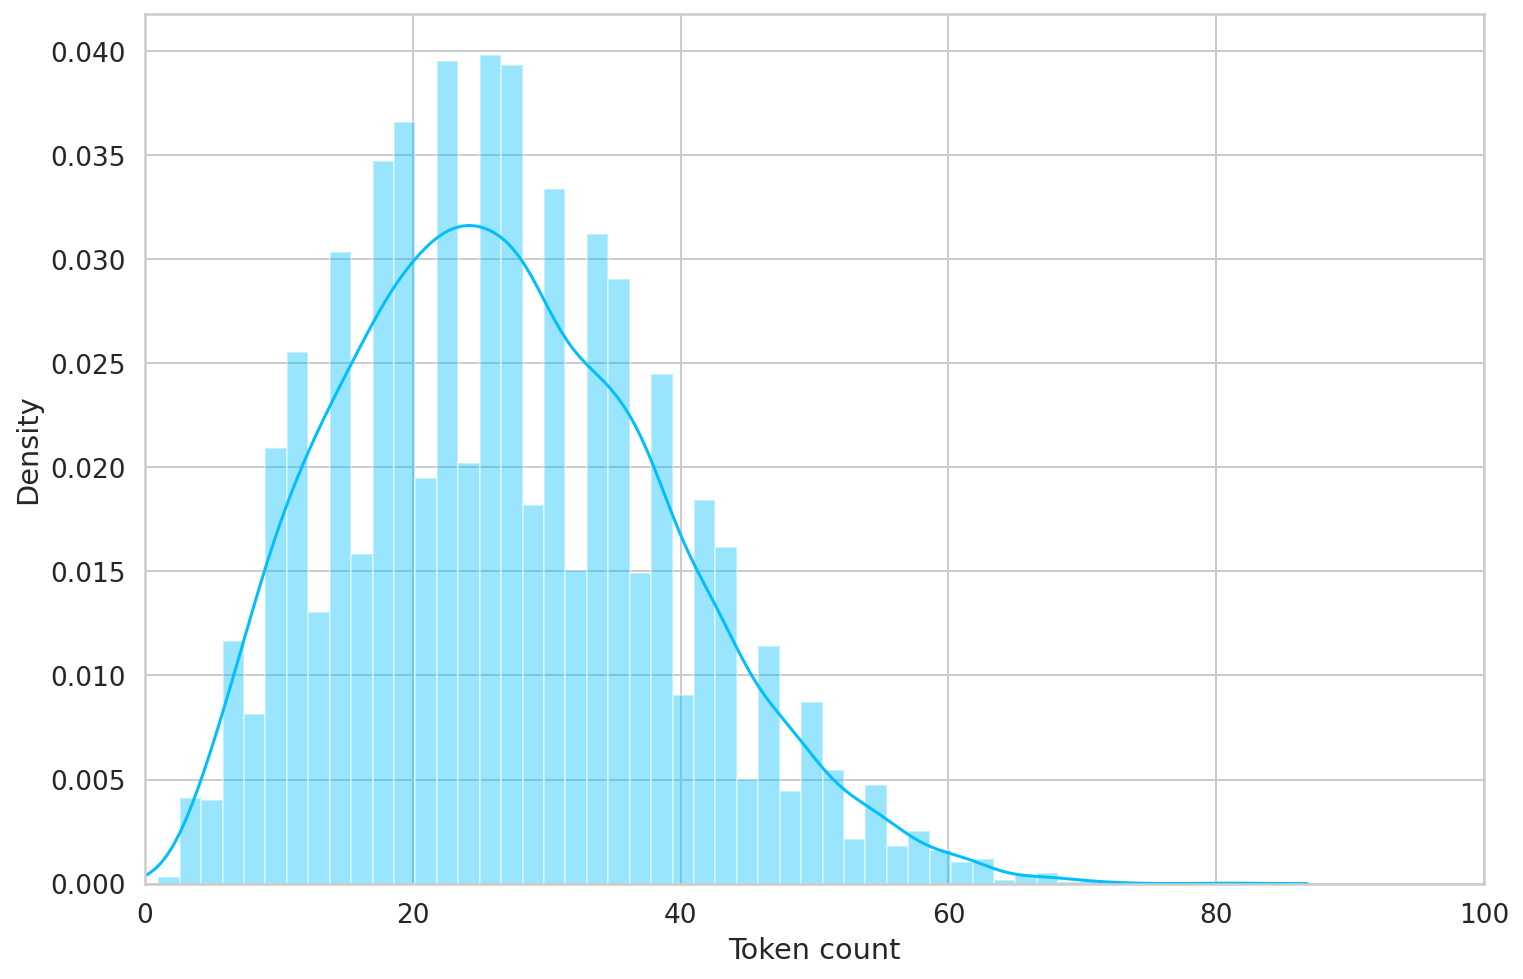

In [ ]:
lens = [len(tokenizer.tokenize(train['text'][i])) for i in range(len(train['text']))]
lens = lens + lens2
sns.distplot(lens)
plt.xlim([0, 100]);
plt.xlabel('Token count');

На данном графике можно ознакомиться с распределением длины токенизированного текста для исследуемой выборки. Вот почему максимальной длиной было выбрано число 80.

#Вспомогательные функции

In [ ]:
def create_new_transf(train, test, tokenizer, MAX_LEN, BATCH_SIZE, PRE_TRAINED_MODEL_NAME):
    if 'roberta' in PRE_TRAINED_MODEL_NAME:
        tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
    elif 'albert' in PRE_TRAINED_MODEL_NAME:
        tokenizer = AlbertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
    else:
        tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
    train_data_loader = create_data_loader(train, tokenizer, MAX_LEN, BATCH_SIZE)
    test_data_loader = create_data_loader(test, tokenizer, MAX_LEN, BATCH_SIZE)
    return train_data_loader, test_data_loader, tokenizer

In [ ]:
def transform_data(
    transf,
    data_loader,
    device,
    n_hidden_layer=None, #номер скрытого слоя, начиная с конца(1, 2,...) для извлечения представления, если не указан, то берется выход трансформера
):
    transf = transf.to(device)
    transf_output = np.array([], dtype=np.float64)
    y = []
    for d in data_loader:
        with torch.no_grad():
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"]
            y = y + list(targets)
            output = transf(
                input_ids=input_ids,
                attention_mask=attention_mask,
                return_dict=False,
                output_hidden_states=True)
            if n_hidden_layer is None:
                x = output[1].to('cpu').numpy()
                transf_output = np.vstack([transf_output, x]) if transf_output.size else x
            elif len(n_hidden_layer) == 1:
                x = output[2][-n_hidden_layer[0]].to('cpu').numpy()
                transf_output = np.vstack([transf_output, x]) if transf_output.size else x  
            else:    
                x = output[2][-n_hidden_layer[0]].to('cpu').numpy()
                for i in range(len(n_hidden_layer) - 1):
                    x = x + output[2][-(n_hidden_layer[i + 1])].to('cpu').numpy()
                transf_output = np.vstack([transf_output, x]) if transf_output.size else x 
    return transf_output, np.array(y)

In [ ]:
def create_data_loader(data, tokenizer, max_len, batch_size):
    df = PlotMovieDataset(
        ds=data,
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        df,
        batch_size=batch_size,
        num_workers=2
    )

In [ ]:
class PlotMovieDataset(Dataset):
  def __init__(self, ds, tokenizer, max_len):
    self.review = ds['text']
    self.targets = ds['label']
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.review)
  def __getitem__(self, item):
    review = self.review[item]
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
def img_of_txt(X, var=0):
    if var[0] == -1:
        return np.mean(X, axis=1) #возвращает среднее представление для 1 объекта, усредненное по всем токенам
    elif var[0] == -2:
        return np.mean(X, axis=2) #возвращает среднее представление для каждого токена, усредненное внутри одного токена
    else:
        return X[:, var].reshape(X.shape[0], X.shape[2]*len(var)) #возвращает представление только одного токена под номером var для 1 объекта

In [ ]:
MAX_LEN=80
BATCH_SIZE = 16

In [ ]:
train_data_loader = create_data_loader(train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test, tokenizer, MAX_LEN, BATCH_SIZE)

#Изучение зависимости качества обучаемой модели от способов получения представления текста из трансформеров

В данном эксперименте мы будем изучать качество обучаемой модели с помощью метрики **accuracy**. В качестве классической модели ML возьмем **логистическую регрессию**. В качестве трансформера возьмем **BERT-large**.

Способы изъятия представлений будут состоять из двух пунктов:
1. Непосредственно способ изъятия:

*   Обработанный трансформером выход для токена CLF; 
*   Один из нескольких последних слоев;
*   Суммирование нескольких последних слоев;

2.  Способ уменьшения размерности признакового пространства для объектов из полученного изъятия: 

*   Усреднение по всем токенам полученного представления для каждого объекта;
*   Усреднение по токену полученного представления для каждого токена;
*   Несколько представлений для нескольких токенов для одного объекта.






##1 эксперимент
---
Используя в качестве способа изъятия **суммирование 3 последних слоев**, как, предположительно, один из самых многообещающих способов, попробуем найти такой способ уменьшения размерности признакового пространства для наших объектов, чтобы наиболее эффективно обучить ML модель.

Способы, перебираемые в этом эксперименте:
1.   Усреднение по всем токенам полученных представлений для каждого объекта;
2.   Усреднение по токену полученного представления для каждого токена;
3.   Представление для первого токена для каждого объекта (отсчет после токена CLF);
4.   Представление для первых пяти токенов для каждого объекта (отсчет после токена CLF);
5.   Представление для первых десяти токенов для каждого объекта (отсчет после токена CLF).
6.   Исходное представление без уменьшения признакового пространства



Прим.: код к данному эксперименту находится [здесь](https://colab.research.google.com/drive/16piALclWOWY7Z4K6cUVaq8LnZ-hkjpDi?usp=sharing).

**Accuracy**

| Усреднение по токенам | Усреднение по токену | Представление по 1 токену | Представление по 1-5 токенам | Представление по 1-10 токенам | Исходное представление |
|---------------|----------|--------------|--------------|--------------|--------------|
| 0.817        | 0.494   | 0.786       | 0.743      | 0.756    | 0.809    |

**CV train**

| Усреднение по токенам | Усреднение по токену | Представление по 1 токену | Представление по 1-5 токенам | Представление по 1-10 токенам | Исходное представление |
|---------------|----------|--------------|--------------|--------------|--------------|
| 0.810        | 0.504   | 0.768       | 0.742      | 0.763    | 0.825    |

###Вывод к 1 эксперименту
---
Как мы можем заметить по результатам этого эксперимента, **усреднение по токенам** дает заметно лучший результат по сравнению с другими способа уменьшения признакового пространства. Мы могли бы не уменьшать признаковое пространство и получить примерно похожий результат для accuracy. Однако это был бы весьма неэффективный вариант, так как наше признаковое пространство было бы в MAX_LENGTH(максимальное кольчиство токенов для одного объекта) раз больше, чем то, которое мы получили, усредняя представление по токенам. Это бы сильно увеличивало время обучения нашей модели, не давая весомый прирост в качестве и лишь увеличивая вероятность ее переобучения.

##2 эксперимент
---
Используя в качестве способа уменьшения признакового пространства **усреднение по токенам**, которое мы выбрали, как самое удобное и эффективное, попробуем найти наиболее подходящий под наши данные способ изъятия представления из нашей модели.

Выбор способа изъятия будем осуществлять из следующих вариантов:

1.   Обработанный трансформером выход для токена CLF; 
2.   Один из нескольких последних слоев: {1, 2, 3, 4, 5};
3.   Суммирование нескольких последних слоев: {1, 1-2, 1-3, 1-4, 1-5};

Данный выбор параметров обусловлен тем, что именно ближе к последним слоям трансформер наиболее полно кодирует наши объекты. Поэтому кажется вполне разумным перебирать именно их.



In [ ]:
train_transf, y_train = transform_data(transf=BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME),data_loader=train_data_loader,device=device,n_hidden_layer=None) #номер скрытого слоя для извлечения представления, если не указан, то берется выход для CLF
test_transf, y_test = transform_data(transf=BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME),data_loader=test_data_loader,device=device,n_hidden_layer=None) #номер скрытого слоя для извлечения представления, если не указан, то берется выход для CLF

In [ ]:
clf = LogisticRegression(max_iter=1000)
print('Token CLF')
print('CV(train): ', sum(cross_val_score(clf, train_transf, y_train, cv=3))/3)
clf.fit(train_transf, y_train)
print('Accuracy: ', accuracy_score(y_test, clf.predict(test_transf)))

Token CLF
CV(train):  0.8310663923316808
Accuracy:  0.8208255159474672


In [ ]:
par = [[i] for i in range(1, 6)]
acc = []
acc_cv = []
for p in par:
    train_transf, y_train = transform_data(transf=BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME),data_loader=train_data_loader,device=device,n_hidden_layer=p) #номер скрытого слоя для извлечения представления, если не указан, то берется выход для CLF
    test_transf, y_test = transform_data(transf=BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME),data_loader=test_data_loader,device=device,n_hidden_layer=p) #номер скрытого слоя для извлечения представления, если не указан, то берется выход для CLF
    clf = LogisticRegression(max_iter=1000)
    acc_cv.append(sum(cross_val_score(clf, img_of_txt(train_transf, var=[-1]), y_train, cv=3))/3)
    clf.fit(img_of_txt(train_transf, var=[-1]), y_train)
    acc.append(accuracy_score(y_test, clf.predict(img_of_txt(test_transf, var=[-1]))))

In [ ]:
par = [np.arange(i) + 1 for i in range(1, 6)]
acc2 = []
acc2_cv = []
for p in par:
    train_transf, y_train = transform_data(transf=BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME),data_loader=train_data_loader,device=device,n_hidden_layer=p) #номер скрытого слоя для извлечения представления, если не указан, то берется выход для CLF
    test_transf, y_test = transform_data(transf=BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME),data_loader=test_data_loader,device=device,n_hidden_layer=p) #номер скрытого слоя для извлечения представления, если не указан, то берется выход для CLF
    clf = LogisticRegression(max_iter=1000)
    acc2_cv.append(sum(cross_val_score(clf, img_of_txt(train_transf, var=[-1]), y_train, cv=3))/3)
    clf.fit(img_of_txt(train_transf, var=[-1]), y_train)
    acc2.append(accuracy_score(y_test, clf.predict(img_of_txt(test_transf, var=[-1]))))

Здесь и далее на графиках отрицательные числа для слоев призваны более наглядно показать по абсолютному значению удаленность от выходного слоя. \
**-1** - выходной слой \
**-2** - слой перед выходным слоем и т.д.

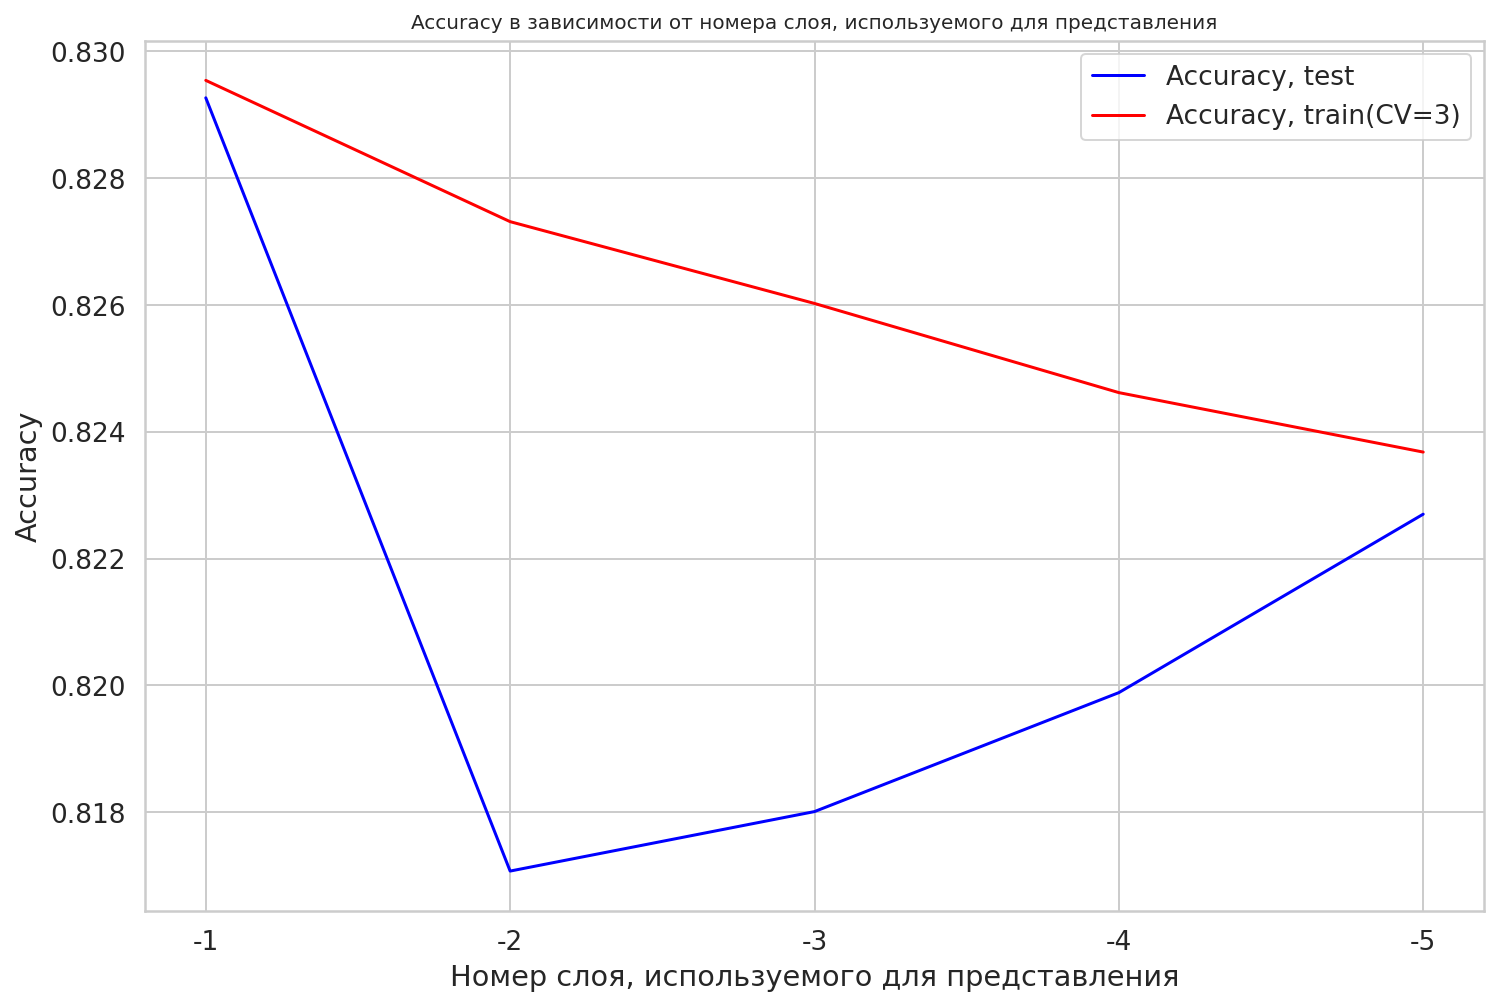

In [ ]:
x1 = np.arange(1, 6)
plt.plot(x1, acc, color='blue', label='Accuracy, test')
plt.plot(x1, acc_cv, color='red', label='Accuracy, train(CV=3)')
plt.xticks(labels=['-1', '-2', '-3', '-4', '-5'], ticks=x1)
plt.xlabel('Номер слоя, используемого для представления')
plt.ylabel('Accuracy')
plt.title('Accuracy в зависимости от номера слоя, используемого для представления', fontsize=10)
plt.grid(True)
plt.legend()
plt.show()

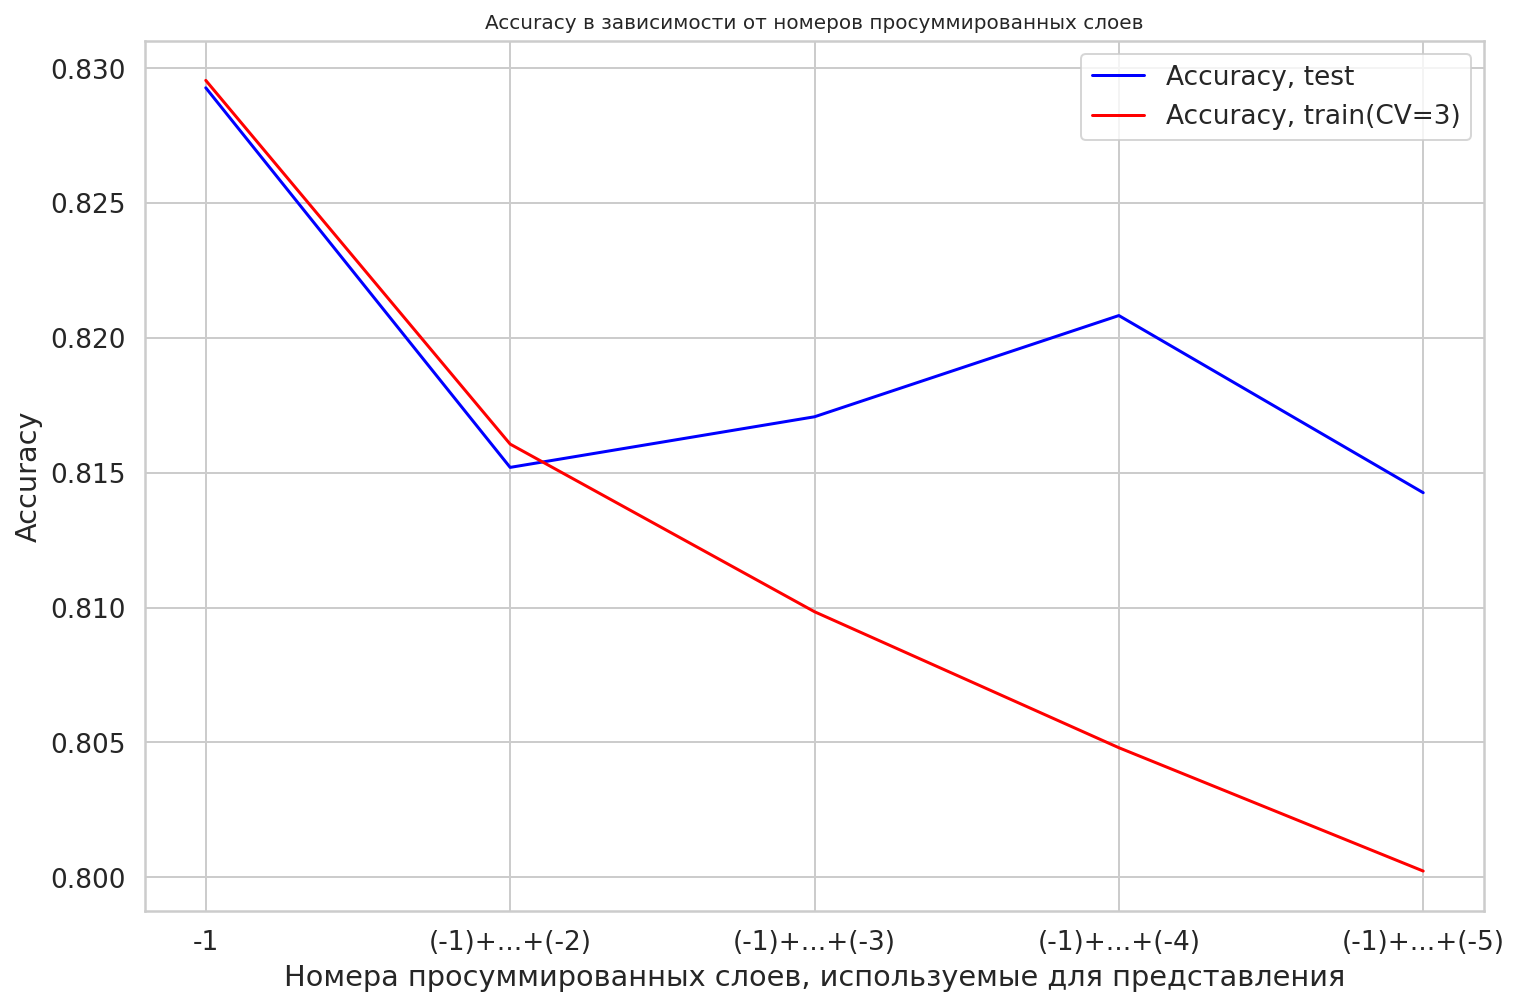

In [ ]:
plt.plot(x1, acc2, color='blue', label='Accuracy, test')
plt.plot(x1, acc2_cv, color='red', label='Accuracy, train(CV=3)')
plt.xticks(labels=['-1', '(-1)+...+(-2)', '(-1)+...+(-3)', '(-1)+...+(-4)', '(-1)+...+(-5)'], ticks=x1)
plt.xlabel('Номера просуммированных слоев, используемые для представления')
plt.ylabel('Accuracy')
plt.title('Accuracy в зависимости от номеров просуммированных слоев', fontsize=10)
plt.grid(True)
plt.legend()
plt.show()

###Вывод ко 2 эксперименту
----
Как мы можем заметить, лучше всего наша модель работает с **представлением, взятым с самого последнего слоя**. В следующих экспериментах будем использовать именно его. \
На графиках видно, что для метрики accuracy значение по каким-то причинам падает при использовании или суммировании со слоем перед выходным(-2), но потом оно постепенно возрастает. Здесь мы можем только предположить, что причиной этому послужило то, что само по себе представление, получаемое на этом слое, не так хорошо характеризует наши отзывы, как на других слоях(этот вывод можно сделать из первого графика к данному эксперименту). 

#Изучение зависимости качества обучаемой модели от выбора трансформера

В данном эксперименте мы будем оценивать качество обучаемой модели с помощью метрики **accuracy** в зависимости от выбора трансформера для нашего представления. В качестве классической модели ML возьмем **логистическую регрессию**. В качестве способа изъятия представлений будем брать **представление, полученное с последнего слоя и усредненное по токенам**.

Виды трансформеров, исследуемых в этом эксперименте:
1. BERT-large-cased
2. BERT-large-uncased
3. BERT-base-cased
4. BERT-base-uncased
5. roBERTa
6. roBERTa-large
7. alBERT-base-v2






##3 эксперимент

Прим.: код к подсчету accuracy для различных трансформеров находится [здесь](https://colab.research.google.com/drive/16piALclWOWY7Z4K6cUVaq8LnZ-hkjpDi?usp=sharing).

| Transformer/Accuracy | train(cv) | test  |
|----------------------|-----------|-------|
| BERT-large-cased     | 0.830     | 0.829 |
| BERT-large-uncased   | 0.842     | 0.825 |
| BERT-base-cased      | 0.806     | 0.816 |
| BERT-base-uncased    | 0.816     | 0.803 |
| roBERTa              | 0.630     | 0.500 |
| roBERTa-large        | 0.843     | 0.851 |
| alBERT-base-v2       | 0.834     | 0.817 |

###Вывод к 3 эксперименту
----
Как мы можем заметить, наилучшего результата удалось добиться при помощи трансформера **roBERTa-large**. В целом можно заметить, что версии large лучше справляются с задачей, чем соответствующие им base версии. \
Заметно хуже остальных моделей оказалась roBERTa-base. Это, вероятно, связано с тем, что у нее меньше параметров, чем у large-версий, а также способ ее обучения отличается от других моделей.

#Изучение зависимости качества обучаемой ML модели от ее выбора

В данном эксперименте мы исследуем зависимость качества от выбора различных моделей для ее подсчета.\
Подсчитываться будем метрика **accuracy**. Для подготовки данных будем использовать трансформер **roBERTa-large**. В качестве способа изъятия представлений будем брать **представление, полученное с последнего слоя и усредненное по токенам**.

Выбор подходящей ML модели будет происходить из следующего набора:
1. Logistic Regression
2. SVC
3. K Neighbors Classifier
4. Decision Tree Classifier
5. Gradient Boosting Classifier
6. Ada Boost Classifier
7. Random Forest Classifier
8. XGB Classifier
9. Cat Boost Classifier

##4 эксперимент

Прим.: код к подсчету accuracy для различных ML-моделей находится [здесь](https://colab.research.google.com/drive/16piALclWOWY7Z4K6cUVaq8LnZ-hkjpDi?usp=sharing).

| Transformer/Accuracy         | train(cv) | test  |
|------------------------------|-----------|-------|
| Logistic Regression          | 0.843     | 0.851 |
| SVC                          | 0.786     | 0.802 |
| K Neighbors Classifier       | 0.696     | 0.690 |
| Decision Tree Classifier     | 0.639     | 0.641 |
| Gradient Boosting Classifier | 0.797     | 0.804 |
| Ada Boost Classifier         | 0.770     | 0.759 |
| Random Forest Classifier     | 0.773     | 0.775 |
| XGB Classifier               | 0.800     | 0.810 |
| Cat Boost Classifier         | 0.823     | 0.826 |

###Вывод к 4 эксперименту
----
Изучив качество работы наших моделей, мы можем видеть, что самой перспективной оказалась логистическая регрессия. Возможно, это связано с тем, что данная модель отлично дополняет наш трансформер до законченного алгоритма, ведь механизм ее работы довольно хорошо сочетается с нейросетью.

#Вывод
----
Таким образом, в данном исследовании были изучены различные модели ML в паре с различными трансформерам и изъятиями из них текстовых представлений с целью максимизировать accurasy в задаче классификации текстов.\
Следует отметить, что из всех исследованных в этой работе трансформеров лучше всего с задачей справился roBERTa-large. При этом представления для текстов были взяты с последнего слоя данного трансформера и усреднены по токенам, а затем использованы в качестве новых признаков для последующего обучения классической ML-модели - логистической регрессии. \
Самое лучшее полученное нами качество оказалось равно **0.851**. Это довольно хороший результат для метрики accuracy. Итак, мы показали, что при правильном выборе модели и трансформера можно достичь неплохих результатов в бинарной классификации текста.

#Источники
----
1. https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/
2. https://huggingface.co/datasets/rotten_tomatoes